# 필요 package import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Version

### 개발 OS 
- windows 11

In [2]:
# python version
import sys
sys.version

'3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]'

In [3]:
# 사용 모델 version
import catboost
import lightgbm
import xgboost
import sklearn

print("Catboost version :", catboost.__version__)
print("LightGBM version:", lightgbm.__version__)
print("XGboost version :", xgboost.__version__)
print("sklearn version :", sklearn.__version__)

Catboost version : 1.2.7
LightGBM version: 4.5.0
XGboost version : 2.1.1
sklearn version : 1.2.2


### 데이터셋 불러오기

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Data Prepocessing

### 13개의 새로운 피처 추가

In [5]:
# 'balance' 컬럼에 로그 변환 적용
train_data['balance_log'] = np.log1p(train_data['balance'])
test_data['balance_log'] = np.log1p(test_data['balance'])

# 첫 번째 연락 여부
train_data['is_first_contact'] = (train_data['pdays'] == -1).astype(int)
test_data['is_first_contact'] = (test_data['pdays'] == -1).astype(int)

# 이전 캠페인 성공 여부
train_data['is_success_previous'] = (train_data['poutcome'] == 'success').astype(int)
test_data['is_success_previous'] = (test_data['poutcome'] == 'success').astype(int)

# 잔고 대비 대출 비율
train_data['balance_to_loan_ratio'] = train_data['balance'] / (1 + (train_data['loan'] == 'yes').astype(int))
test_data['balance_to_loan_ratio'] = test_data['balance'] / (1 + (test_data['loan'] == 'yes').astype(int))

# 잔고가 높은지 여부 플래그 (balance > 5000)
train_data['high_balance_flag'] = (train_data['balance'] > 5000).astype(int)
test_data['high_balance_flag'] = (test_data['balance'] > 5000).astype(int)

# 전화기로 연락했는지 여부
train_data['is_telephone_contact'] = (train_data['contact'] == 'telephone').astype(int)
test_data['is_telephone_contact'] = (test_data['contact'] == 'telephone').astype(int)

# 캠페인당 평균 통화 시간
train_data['contact_duration_per_call'] = train_data['duration'] / (train_data['campaign'] + 1)
test_data['contact_duration_per_call'] = test_data['duration'] / (test_data['campaign'] + 1)

# 성수기(5월, 8월)에 연락했는지 여부
peak_months = ['may', 'aug']
train_data['is_contact_in_peak_months'] = train_data['month'].isin(peak_months).astype(int)
test_data['is_contact_in_peak_months'] = test_data['month'].isin(peak_months).astype(int)

# 분기 데이터
def map_to_quarter(month):
    if month in ['jan', 'feb', 'mar']:
        return 1
    elif month in ['apr', 'may', 'jun']:
        return 2
    elif month in ['jul', 'aug', 'sep']:
        return 3
    elif month in ['oct', 'nov', 'dec']:
        return 4

train_data['quarter'] = train_data['month'].apply(map_to_quarter)
test_data['quarter'] = test_data['month'].apply(map_to_quarter)

# 연령대 그룹화
def categorize_age(age):
    if age < 20:
        return '10대 미만'
    elif 20 <= age < 30:
        return '20대'
    elif 30 <= age < 40:
        return '30대'
    elif 40 <= age < 50:
        return '40대'
    elif 50 <= age < 60:
        return '50대'
    elif 60 <= age < 70:
        return '60대'
    else:
        return '70대 이상'

train_data['age_group'] = train_data['age'].apply(categorize_age)
test_data['age_group'] = test_data['age'].apply(categorize_age)

# 캠페인 횟수 대비 통화 시간 비율
train_data['campaign_per_duration'] = train_data['campaign'] / (train_data['duration'] + 1)
test_data['campaign_per_duration'] = test_data['campaign'] / (test_data['duration'] + 1)

# 나이가 30 이하인지 여부
train_data['is_young'] = (train_data['age'] <= 30).astype(int)
test_data['is_young'] = (test_data['age'] <= 30).astype(int)


C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82108\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## inf값 및 결측값 처리
- balance에 로그변환을 취해 발생한 무한값을 결측값으로 변환
- 수치형 변수는 평균값으로, 범주형 변수는 최빈값으로 결측값 대체 

In [6]:
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [7]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome',
    'quarter', 'age_group']
numerical_cols = ['age', 'balance', 'balance_log', 'duration', 'campaign']
for col in numerical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mean())
    test_data[col] = test_data[col].fillna(test_data[col].mean())

for col in categorical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])
print(train_data.isnull().sum())
print(test_data.isnull().sum())

ID                           0
age                          0
job                          0
marital                      0
education                    0
default                      0
balance                      0
housing                      0
loan                         0
contact                      0
day                          0
month                        0
duration                     0
campaign                     0
pdays                        0
previous                     0
poutcome                     0
label                        0
balance_log                  0
is_first_contact             0
is_success_previous          0
balance_to_loan_ratio        0
high_balance_flag            0
is_telephone_contact         0
contact_duration_per_call    0
is_contact_in_peak_months    0
quarter                      0
age_group                    0
campaign_per_duration        0
is_young                     0
dtype: int64
ID                               0
age                   

## 전처리 확인

In [8]:
train_data

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,is_success_previous,balance_to_loan_ratio,high_balance_flag,is_telephone_contact,contact_duration_per_call,is_contact_in_peak_months,quarter,age_group,campaign_per_duration,is_young
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,...,0,358.0,0,0,20.000000,1,2,30대,0.039604,0
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,...,0,-53.0,0,0,86.000000,1,2,30대,0.005780,0
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,...,0,207.0,0,0,28.000000,0,1,30대,0.017544,0
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,...,1,638.0,0,0,163.000000,1,2,30대,0.003058,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,...,0,826.0,0,0,128.000000,1,2,30대,0.003891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,train31643,60,retired,married,secondary,no,3932,yes,no,unknown,...,0,3932.0,0,0,135.666667,1,2,60대,0.004902,0
31643,train31644,44,blue-collar,married,unknown,no,15578,yes,no,unknown,...,0,15578.0,1,0,200.500000,1,2,40대,0.002488,0
31644,train31645,54,unemployed,single,secondary,no,3611,yes,no,cellular,...,0,3611.0,0,0,40.500000,0,1,50대,0.012195,0
31645,train31646,33,services,married,secondary,yes,2,no,no,cellular,...,0,2.0,0,0,22.666667,1,2,30대,0.036496,0


In [9]:
test_data

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,is_success_previous,balance_to_loan_ratio,high_balance_flag,is_telephone_contact,contact_duration_per_call,is_contact_in_peak_months,quarter,age_group,campaign_per_duration,is_young
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,...,0,6410.0,1,0,33.666667,0,4,50대,0.019608,0
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,...,0,282.0,0,0,52.000000,0,1,50대,0.012739,0
2,test00003,34,management,married,secondary,no,355,no,no,cellular,...,0,355.0,0,0,78.500000,1,3,30대,0.009524,0
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,...,0,568.0,0,0,85.454545,1,3,50대,0.010627,0
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,...,0,6728.0,1,0,50.400000,1,3,30대,0.015810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,test13560,32,management,single,tertiary,no,19985,no,no,cellular,...,0,19985.0,1,0,102.666667,0,1,30대,0.008104,0
13560,test13561,31,student,single,tertiary,no,307,no,no,cellular,...,0,307.0,0,0,199.000000,0,4,30대,0.003344,0
13561,test13562,38,blue-collar,married,secondary,no,20,yes,no,unknown,...,0,20.0,0,0,201.000000,1,2,30대,0.002481,0
13562,test13563,26,management,single,tertiary,no,3,yes,no,cellular,...,0,3.0,0,0,53.000000,0,3,20대,0.009346,1


# Encoding
- Label Encoder

In [10]:
label_encoders = {}
for col in categorical_cols:
   le = LabelEncoder()
   train_data[col] = le.fit_transform(train_data[col])
   test_data[col] = le.transform(test_data[col])
   label_encoders[col] = le

# Modeling
- Hard voting Ensemble(Catboost, LightGBM, XGboost)
- Cross-validation (fold=5, StratifiedKFold)

In [11]:
train_data = train_data.drop(columns=['ID'])
test_data = test_data.drop(columns=['ID'])

In [12]:
X = train_data.drop(columns=['label'])
y = train_data['label']

test_features = test_data.drop(columns=['label'])

In [13]:
# CatBoost hyperparameters
catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.04,
    'depth': 4,
    'eval_metric': 'F1',
    'verbose': 100,
    'random_seed': 42
}

# LightGBM hyperparameters
lgbm_params = {
    'learning_rate': 0.074,
    'num_leaves': 37,
    'max_depth': 12,
    'min_child_samples': 53,
    'subsample': 0.86,
    'colsample_bytree': 0.92,
    'reg_alpha': 2.5,
    'reg_lambda': 0.001
}

# XGBoost hyperparameters
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 5,
    'learning_rate': 0.02,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'gamma': 0.93,
    'min_child_weight': 1,
    'scale_pos_weight': 1.47,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'random_state': 42,
    'use_label_encoder': False,
    'verbosity': 1
}

# K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 저장용 변수 초기화
catboost_oof = np.zeros(len(test_features))
lgbm_oof = np.zeros(len(test_features))
xgb_oof = np.zeros(len(test_features))
final_oof = np.zeros(len(test_features))

f1_scores = []  # F1-점수 저장

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}")
    
    # Train/Validation split
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # CatBoost 모델 학습
    cat_model = CatBoostClassifier(**catboost_params)
    cat_model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=1000,
        use_best_model=True
    )
    
    # LightGBM 모델 학습
    lgbm_model = LGBMClassifier(**lgbm_params)
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )
    
    # XGBoost 모델 학습
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )
    
    # Validation 예측
    cat_valid_proba = cat_model.predict_proba(X_valid)[:, 1]
    lgbm_valid_proba = lgbm_model.predict_proba(X_valid)[:, 1]
    xgb_valid_proba = xgb_model.predict_proba(X_valid)[:, 1]
    
    # Hard Voting (확률 평균)
    valid_ensemble_proba = (cat_valid_proba + lgbm_valid_proba + xgb_valid_proba) / 3
    y_pred = (valid_ensemble_proba > 0.3).astype(int)  # Threshold = 0.3
    
    # F1 점수 계산
    f1 = f1_score(y_valid, y_pred)
    f1_scores.append(f1)
    print(f"F1 Score for Fold {fold + 1}: {f1}")
    
    # Test 예측 및 OOF 저장
    catboost_oof += cat_model.predict_proba(test_features)[:, 1] / kf.n_splits
    lgbm_oof += lgbm_model.predict_proba(test_features)[:, 1] / kf.n_splits
    xgb_oof += xgb_model.predict_proba(test_features)[:, 1] / kf.n_splits

# 최종 앙상블 예측
final_oof = (catboost_oof + lgbm_oof + xgb_oof) / 3

Fold 1
0:	learn: 0.2826202	test: 0.3020833	best: 0.3020833 (0)	total: 173ms	remaining: 28m 49s
100:	learn: 0.4201128	test: 0.4462659	best: 0.4468864 (98)	total: 2.94s	remaining: 4m 47s
200:	learn: 0.4885596	test: 0.5058626	best: 0.5058626 (199)	total: 5.74s	remaining: 4m 39s
300:	learn: 0.5298930	test: 0.5323625	best: 0.5323625 (300)	total: 8.89s	remaining: 4m 46s
400:	learn: 0.5570511	test: 0.5351438	best: 0.5412330 (382)	total: 11.7s	remaining: 4m 40s
500:	learn: 0.5792059	test: 0.5261490	best: 0.5412330 (382)	total: 14.6s	remaining: 4m 36s
600:	learn: 0.5934200	test: 0.5337520	best: 0.5412330 (382)	total: 17.4s	remaining: 4m 31s
700:	learn: 0.6062802	test: 0.5379845	best: 0.5412330 (382)	total: 20.1s	remaining: 4m 26s
800:	learn: 0.6204000	test: 0.5413766	best: 0.5429234 (794)	total: 23.1s	remaining: 4m 25s
900:	learn: 0.6323120	test: 0.5419554	best: 0.5447531 (810)	total: 25.8s	remaining: 4m 20s
1000:	learn: 0.6435093	test: 0.5446154	best: 0.5468510 (992)	total: 28.2s	remaining: 4m

C:\Users\82108\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-aucpr:0.55785
[16]	validation_0-aucpr:0.55850
[17]	validation_0-aucpr:0.55944
[18]	validation_0-aucpr:0.56130
[19]	validation_0-aucpr:0.56156
[20]	validation_0-aucpr:0.56449
[21]	validation_0-aucpr:0.56433
[22]	validation_0-aucpr:0.56503
[23]	validation_0-aucpr:0.56576
[24]	validation_0-aucpr:0.56598
[25]	validation_0-aucpr:0.56620
[26]	validation_0-aucpr:0.56494
[27]	validation_0-aucpr:0.56704
[28]	validation_0-aucpr:0.56739
[29]	validation_0-aucpr:0.56803
[30]	validation_0-aucpr:0.56966
[31]	validation_0-aucpr:0.57055
[32]	validation_0-aucpr:0.57030
[33]	validation_0-aucpr:0.57015
[34]	validation_0-aucpr:0.57159
[35]	validation_0-aucpr:0.57229
[36]	validation_0-aucpr:0.57233
[37]	validation_0-aucpr:0.57250
[38]	validation_0-aucpr:0.57508
[39]	validation_0-aucpr:0.57418
[40]	validation_0-aucpr:0.57486
[41]	validation_0-aucpr:0.57573
[42]	validation_0-aucpr:0.57642
[43]	validation_0-aucpr:0.57678
[44]	validation_0-aucpr:0.57736
[45]	validation_0-aucpr:0.57819
[46]	val

C:\Users\82108\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-aucpr:0.54746
[11]	validation_0-aucpr:0.54682
[12]	validation_0-aucpr:0.54922
[13]	validation_0-aucpr:0.55217
[14]	validation_0-aucpr:0.55149
[15]	validation_0-aucpr:0.55279
[16]	validation_0-aucpr:0.55297
[17]	validation_0-aucpr:0.55458
[18]	validation_0-aucpr:0.55330
[19]	validation_0-aucpr:0.55216
[20]	validation_0-aucpr:0.55325
[21]	validation_0-aucpr:0.55170
[22]	validation_0-aucpr:0.55285
[23]	validation_0-aucpr:0.55421
[24]	validation_0-aucpr:0.55398
[25]	validation_0-aucpr:0.55407
[26]	validation_0-aucpr:0.55461
[27]	validation_0-aucpr:0.55449
[28]	validation_0-aucpr:0.55415
[29]	validation_0-aucpr:0.55546
[30]	validation_0-aucpr:0.55623
[31]	validation_0-aucpr:0.55539
[32]	validation_0-aucpr:0.55649
[33]	validation_0-aucpr:0.55831
[34]	validation_0-aucpr:0.55934
[35]	validation_0-aucpr:0.55998
[36]	validation_0-aucpr:0.56034
[37]	validation_0-aucpr:0.56011
[38]	validation_0-aucpr:0.55995
[39]	validation_0-aucpr:0.56153
[40]	validation_0-aucpr:0.56180
[41]	val

C:\Users\82108\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:0.52579
[8]	validation_0-aucpr:0.52582
[9]	validation_0-aucpr:0.52551
[10]	validation_0-aucpr:0.52488
[11]	validation_0-aucpr:0.52553
[12]	validation_0-aucpr:0.52701
[13]	validation_0-aucpr:0.53098
[14]	validation_0-aucpr:0.53119
[15]	validation_0-aucpr:0.53016
[16]	validation_0-aucpr:0.53131
[17]	validation_0-aucpr:0.53234
[18]	validation_0-aucpr:0.53230
[19]	validation_0-aucpr:0.53199
[20]	validation_0-aucpr:0.53227
[21]	validation_0-aucpr:0.53217
[22]	validation_0-aucpr:0.53155
[23]	validation_0-aucpr:0.53485
[24]	validation_0-aucpr:0.53521
[25]	validation_0-aucpr:0.53605
[26]	validation_0-aucpr:0.53597
[27]	validation_0-aucpr:0.53592
[28]	validation_0-aucpr:0.53889
[29]	validation_0-aucpr:0.54030
[30]	validation_0-aucpr:0.54174
[31]	validation_0-aucpr:0.54105
[32]	validation_0-aucpr:0.54016
[33]	validation_0-aucpr:0.54115
[34]	validation_0-aucpr:0.54330
[35]	validation_0-aucpr:0.54332
[36]	validation_0-aucpr:0.54432
[37]	validation_0-aucpr:0.54293
[38]	valida

C:\Users\82108\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:0.57196
[9]	validation_0-aucpr:0.56893
[10]	validation_0-aucpr:0.57218
[11]	validation_0-aucpr:0.57235
[12]	validation_0-aucpr:0.56924
[13]	validation_0-aucpr:0.57244
[14]	validation_0-aucpr:0.57310
[15]	validation_0-aucpr:0.57339
[16]	validation_0-aucpr:0.57322
[17]	validation_0-aucpr:0.57296
[18]	validation_0-aucpr:0.57364
[19]	validation_0-aucpr:0.57376
[20]	validation_0-aucpr:0.57245
[21]	validation_0-aucpr:0.57339
[22]	validation_0-aucpr:0.57286
[23]	validation_0-aucpr:0.57370
[24]	validation_0-aucpr:0.57314
[25]	validation_0-aucpr:0.57501
[26]	validation_0-aucpr:0.57318
[27]	validation_0-aucpr:0.57335
[28]	validation_0-aucpr:0.57735
[29]	validation_0-aucpr:0.57788
[30]	validation_0-aucpr:0.57802
[31]	validation_0-aucpr:0.57698
[32]	validation_0-aucpr:0.57743
[33]	validation_0-aucpr:0.57775
[34]	validation_0-aucpr:0.57831
[35]	validation_0-aucpr:0.57836
[36]	validation_0-aucpr:0.57820
[37]	validation_0-aucpr:0.57848
[38]	validation_0-aucpr:0.57961
[39]	valid

C:\Users\82108\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:17:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:0.51968
[7]	validation_0-aucpr:0.52217
[8]	validation_0-aucpr:0.52079
[9]	validation_0-aucpr:0.52157
[10]	validation_0-aucpr:0.52495
[11]	validation_0-aucpr:0.52748
[12]	validation_0-aucpr:0.52609
[13]	validation_0-aucpr:0.52647
[14]	validation_0-aucpr:0.52509
[15]	validation_0-aucpr:0.52476
[16]	validation_0-aucpr:0.52689
[17]	validation_0-aucpr:0.52744
[18]	validation_0-aucpr:0.52837
[19]	validation_0-aucpr:0.52825
[20]	validation_0-aucpr:0.52864
[21]	validation_0-aucpr:0.52794
[22]	validation_0-aucpr:0.52853
[23]	validation_0-aucpr:0.52885
[24]	validation_0-aucpr:0.52919
[25]	validation_0-aucpr:0.52970
[26]	validation_0-aucpr:0.53062
[27]	validation_0-aucpr:0.53093
[28]	validation_0-aucpr:0.53098
[29]	validation_0-aucpr:0.53265
[30]	validation_0-aucpr:0.53376
[31]	validation_0-aucpr:0.53384
[32]	validation_0-aucpr:0.53383
[33]	validation_0-aucpr:0.53449
[34]	validation_0-aucpr:0.53429
[35]	validation_0-aucpr:0.53456
[36]	validation_0-aucpr:0.53561
[37]	validat

# 모델평가

In [30]:
# Cross-Validation 결과 요약
mean_f1_score = np.mean(f1_scores)
print(f"Cross-Validation(5-Fold Stratified K-Fold) 결과:")
print(f"- 각 Fold의 F1-Score: {f1_scores}")
print(f"- 평균 F1-Score: {mean_f1_score:.3f}")

valid_f1_score = f1_score(y_valid, (valid_ensemble_proba > 0.3).astype(int)) 

print(f"\n테스트 데이터 결과:")
print(f"- F1-Score: {valid_f1_score:.3f}")


Cross-Validation(5-Fold Stratified K-Fold) 결과:
- 각 Fold의 F1-Score: [0.6309255079006771, 0.6126436781609195, 0.6208476517754868, 0.6424809830310123, 0.6385681293302541]
- 평균 F1-Score: 0.629

테스트 데이터 결과:
- F1-Score: 0.639


F1 Scores for each fold: [0.6309255079006771, 0.6126436781609195, 0.6208476517754868, 0.6424809830310123, 0.6385681293302541]
Mean F1 Score: 0.62909319003967


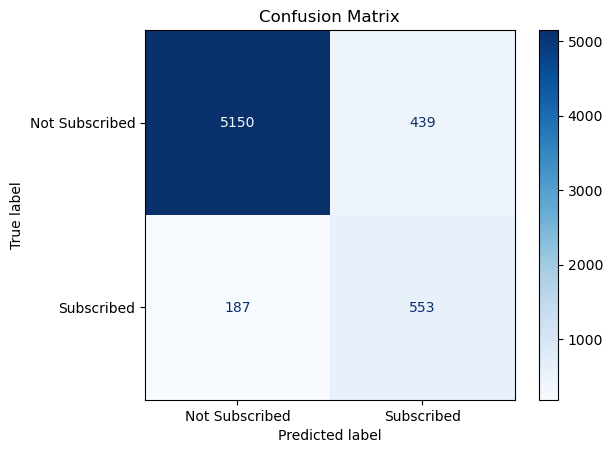

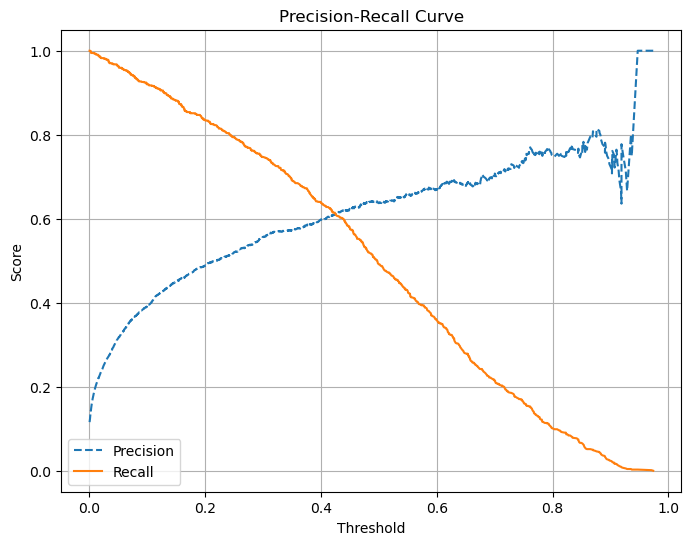

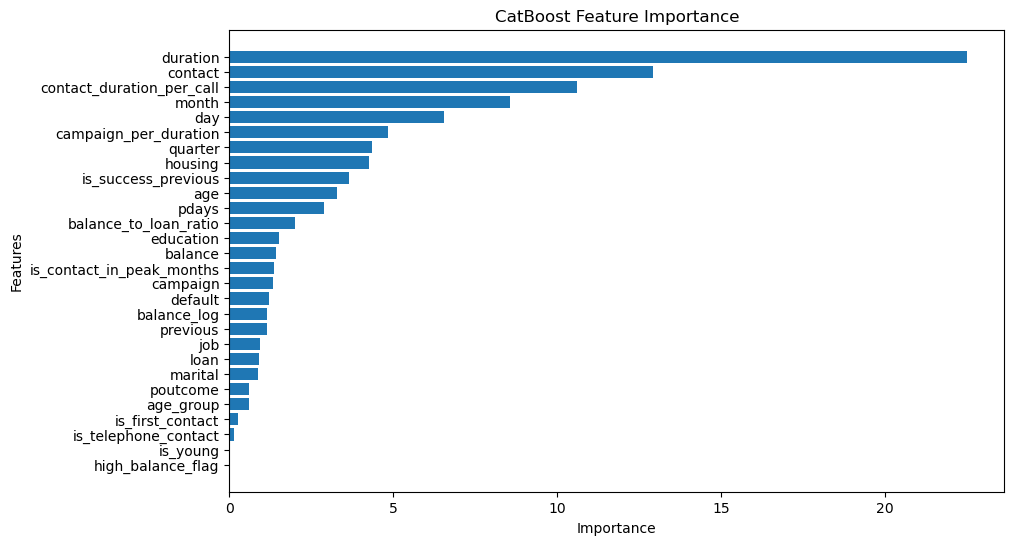

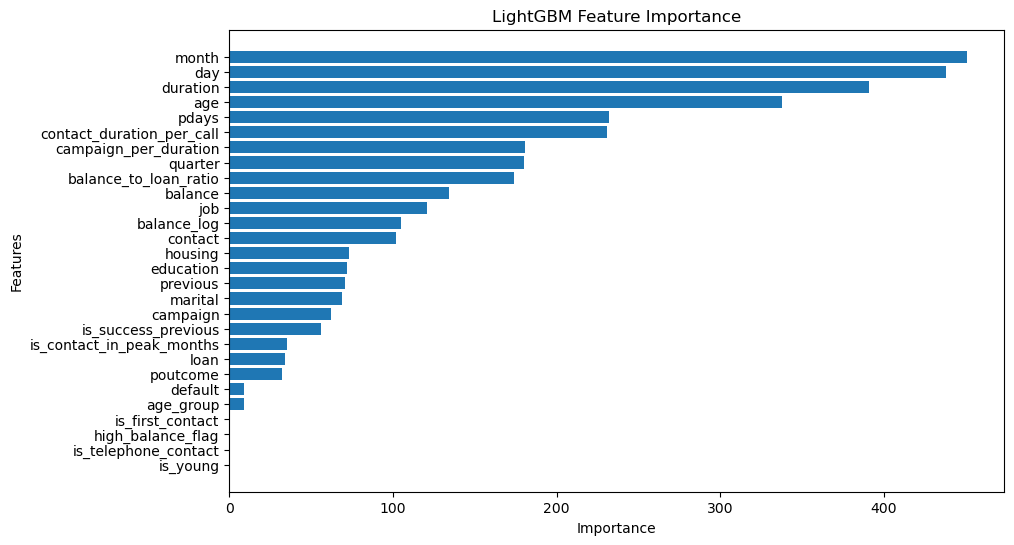

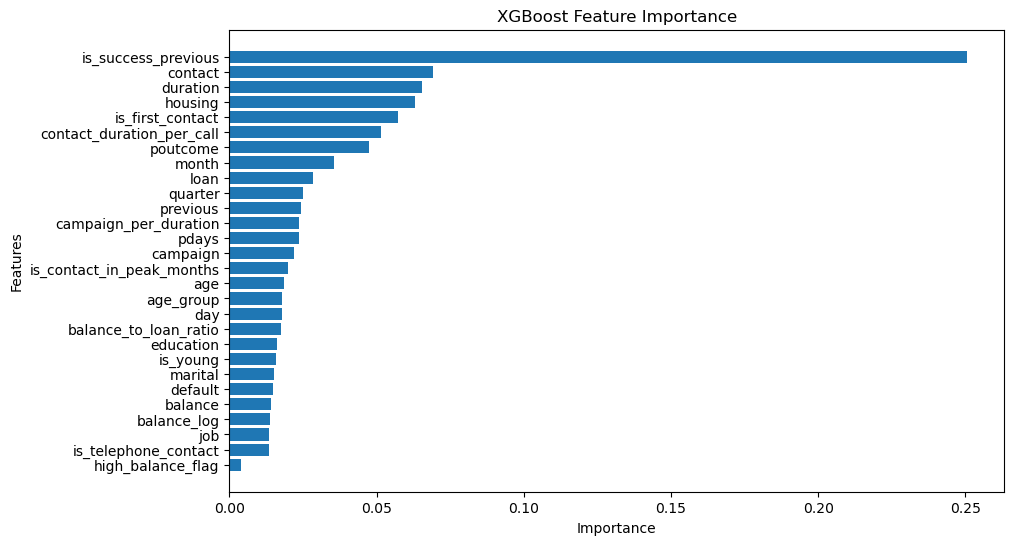

In [32]:
# F1 Score 요약
print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))

# 테스트 데이터 예측
final_predictions = (final_oof > 0.3).astype(int)

# 1. 혼동 행렬(Confusion Matrix)
cm = confusion_matrix(y_valid, y_pred)  # 검증 데이터의 마지막 Fold 결과 사용
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Subscribed", "Subscribed"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 2. Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, valid_ensemble_proba)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle='-')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# 3. Feature Importance (CatBoost, LightGBM, XGBoost)

# CatBoost Feature Importance
cat_features = X.columns
cat_importances = cat_model.get_feature_importance()

cat_importances_df = pd.DataFrame({
    'Feature': cat_features,
    'Importance': cat_importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(cat_importances_df['Feature'], cat_importances_df['Importance'])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# LightGBM Feature Importance
lgbm_importances = lgbm_model.feature_importances_
lgbm_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(lgbm_importances_df['Feature'], lgbm_importances_df['Importance'])
plt.gca().invert_yaxis() 
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# XGBoost Feature Importance
xgb_importances = xgb_model.feature_importances_
xgb_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(xgb_importances_df['Feature'], xgb_importances_df['Importance'])
plt.gca().invert_yaxis() 
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Submission

In [16]:
predictions = []
for prob in final_oof:
    if prob > 0.42:
        predictions.append(1)  # Positive
    else:
        predictions.append(0)  # Negative


In [21]:
submission = pd.read_csv('./submission_example.csv')
submission['label'] = predictions

In [22]:
submission.to_csv('sub_hardvoting.csv', index = False)